In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/')

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils import display_prediction
from gta5_ import GTA5
from Cityscapes import Cityscapes
from bisenetv2 import BiSeNetV2

ModuleNotFoundError: ignored

In [ ]:


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 12       # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 25        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1           # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 40

RESIZED_H = 256
RESIZED_W = 512

MODE = 'LOAD'       #TRAIN or LOAD_AND_TRAIN or LOAD
MODEL_PATH = '/content/drive/My Drive/gta5_partiton_A.tar' #File to save the model in

In [4]:
mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]

normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([resizer_bicubic])
eval_transform = transforms.Compose([resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])


train_set = GTA5('drive/MyDrive/', transform=train_transform, target_transform=target_transform)
val_set_A = Cityscapes('drive/MyDrive/', partition_type='A', split='val', transform=eval_transform, target_transform=target_transform)
val_set_B = Cityscapes('drive/MyDrive/', partition_type='B', split='val', transform=eval_transform, target_transform=target_transform)


In [5]:
val_set_A


Dataset Cityscapes
    Number of datapoints: 42
    Root location: drive/MyDrive/
    StandardTransform
Transform: Compose(
               Resize(size=(256, 512), interpolation=bicubic, max_size=None, antialias=None)
           )
Target transform: Compose(
                      Resize(size=(256, 512), interpolation=nearest, max_size=None, antialias=None)
                  )

In [6]:
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_A_dataloader = DataLoader(val_set_A, batch_size=BATCH_SIZE, shuffle=True)
val_B_dataloader = DataLoader(val_set_B, batch_size=BATCH_SIZE, shuffle=True)



In [7]:

print(len(train_set))
print(len(train_dataloader))

print(len(val_set_A))
print(len(val_A_dataloader))

print(len(val_set_B))
print(len(val_B_dataloader))


500
42
42
4
250
21


(256, 512)
[[ 10  10  10 ...   2   2   2]
 [ 10  10  10 ...   2   2   2]
 [ 10  10  10 ...   2   2   2]
 ...
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]
 [  0   0   0 ... 255 255 255]]
[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  16 255]


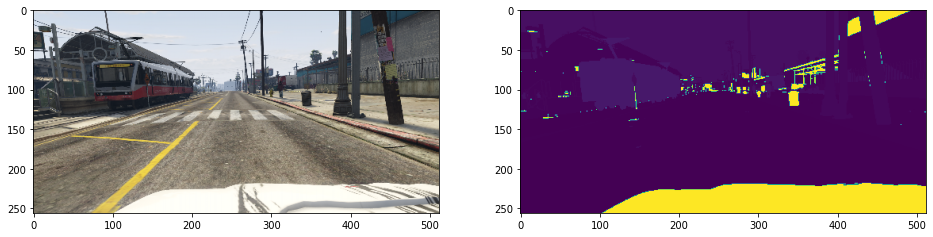

In [8]:
img, lbl = train_set.__getitem__(19)
print(lbl.shape)
print(lbl)

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
print(np.unique(lbl))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(lbl)


In [9]:
net = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
net = net.to(DEVICE)

In [10]:
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(DEVICE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.8 MB/s eta 0:00:00


In [11]:
# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=255) # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of the net
# (nn.Module objects implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [12]:
def train_epoch(net, dataloader, lr=0.01, optimizer=optimizer, loss_fn=criterion):
    net.train()

    total_loss, miou, count = 0, 0, 0
    for i, (images, masks) in enumerate(dataloader):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.squeeze().to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()

        out = net(images)
        loss = loss_fn(out, masks) 
        loss.backward()
        optimizer.step()

        total_loss += loss
        miou += metric(out, masks)
        count += 1
        if i%LOG_FREQUENCY == 0:
            print("  minibatch {}: train mIoU = {} train loss = {}".format(i, miou.item()/count, total_loss.item()/count))
    return total_loss.item()/count, miou.item()/count

def validate(net, dataloader, loss_fn=criterion):
    net.eval()
    loss, miou, count = 0, 0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(DEVICE)
            masks = masks.squeeze().to(DEVICE)

            out = net(images)
            loss += loss_fn(out, masks) 
            miou += metric(out, masks)
            count += 1
    return loss.item()/count, miou.item()/count

def train(net, train_dataloader, val_B_dataloader, history=None, starting_epoch=0, optimizer=optimizer, lr=0.01, epochs=10, loss_fn=criterion):
    history = history or {'train_loss' : [0.0], 'train_miou': [0.0], 'val_loss': [0.0], 'val_miou': [0.0]} 

    print(f'Lr: {lr}\nBatch size: {BATCH_SIZE}\nEpochs: {epochs}\nLoss function: {loss_fn}\nOptimizer: {optimizer}')

    for ep in range(starting_epoch, starting_epoch + epochs):
        print(f'----------- EPOCH {ep+1} -----------')
        train_loss, train_miou = train_epoch(net, train_dataloader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        val_loss, val_miou = validate(net, val_B_dataloader, loss_fn=loss_fn)
        print(f"Train mIoU={train_miou:.3f}, Val mIoU={val_miou:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
        
        save = False
        if val_miou > max(history['val_miou']): #If this is the best validation mIoU, save the model
          save = True
          print(f"MODEL SAVED WITH mIoU = {val_miou}") 

        history['train_loss'].append(train_loss)
        history['train_miou'].append(train_miou)
        history['val_loss'].append(val_loss)
        history['val_miou'].append(val_miou)
        display_prediction(net, val_set_B, random=False)
        scheduler.step()
                
        if save == True:
            torch.save({
                'model_state_dict': net.state_dict(),
                'optim_state_dict': optimizer.state_dict(),
                'epoch': ep,
                'history': history,
                'batch_size': BATCH_SIZE,
                'lr': lr,
                'resized_height': RESIZED_H,
                'resized_width': RESIZED_W,
            }, MODEL_PATH)

    return history

def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['train_miou'], label='Training mIoU')
    plt.plot(history['val_miou'], label='Validation mIoU')
    plt.legend()
    plt.subplot(122)
    plt.plot(history['train_loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.legend()

In [13]:
def load_model(path):
    checkpoint = torch.load(MODEL_PATH)
    net.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    return epoch, history

if MODE == 'LOAD':
    epoch, history = load_model(MODEL_PATH)
    net.eval()
    print(f'Loaded pre-trained model at epoch {epoch}')
    plot_history(history)
elif MODE == 'LOAD_AND_TRAIN':
    epoch, history = load_model(MODEL_PATH)
    print(f'Loaded pre-trained model at epoch {epoch}')
    plot_history(history)
    history = train(net, train_dataloader, val_A_dataloader, history, starting_epoch=epoch, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
    plot_history(history)
elif MODE == 'TRAIN':
    history = train(net, train_dataloader, val_A_dataloader, history=None, starting_epoch=0, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
    plot_history(history)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
display_prediction(net, train_set, random=True)
display_prediction(net, val_set_A, random=True)